# Adam: Exercise

For this exercise we will be build Adam up from scratch starting with regular gradient descent. We will also be utilizing mini batches to introduce stochasticity to the optimization. 

We will be working with the mnist_784 data set and a simple shallow neural network. 

If you do not have scikit-learn then you can get it here: https://scikit-learn.org/stable/install.html

This code is heavily inspired by Doug’s code from CSCI 447/547 lecture 05_multilayer_perceptron.

First we need to get the data, define the network and define some functions to perform on the data. You don’t need to do anything with this first block of code. 

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# In order to run this in class, we're going to reduce the dataset by a factor of 5
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X[::5]
y = y.astype(int)[::5]
X, X_test, y, y_test = train_test_split(X, y)

# Here we specify the size of our neural network.
# We are mapping from 784 to 10 with 256 hiden layer nodes.

m = len(X)
n_0 = 784
n_1 = 256
N = 10


# Function to convert categorical labels into one-hot matrix.
def convert_to_one_hot(y, n_classes):
    T = np.zeros((y.shape[0], n_classes))
    for t, yy in zip(T, y):
        t[yy] = 1
    return T


# Convert the data to one hot notation
one_hot_y_actual = convert_to_one_hot(y, N)
one_hot_y_test = convert_to_one_hot(y_test, N)


# Sigmoid function (activation)
def sigmoid(a):
    return 1. / (1 + np.exp(-a))


# Softmax function (final layer for classification)
def softmax(A):
    numerator = np.exp(A)
    denominator = numerator.sum(axis=1)
    return numerator / denominator[:, np.newaxis]


# Categorical cross-entropy
def L(T, S, W1, W2, alpha_1=1e-2, alpha_2=1e-5):
    return -1. / len(T) * np.sum(T * np.log(S)) + np.sum(0.5 * alpha_1 * W1 ** 2) + np.sum(0.5 * alpha_2 * W2 ** 2)


# Run the neural network forward, given some weights and biases
def feedforward(X, W1, W2, b1, b2):
    # Feedforward
    A1 = X @ W1 + b1
    Z1 = sigmoid(A1)
    A2 = Z1 @ W2 + b2
    y_pred = softmax(A2)
    return y_pred, Z1


# Compute the neural network gradients using backpropagation
def backpropogate(y_pred, Z1, X, y_obs, alpha_1=1e-2, alpha_2=1e-5):
    # Backpropogate
    delta_2 = (1. / len(y_pred)) * (y_pred - y_obs)
    grad_W2 = Z1.T @ delta_2 + alpha_2 * W2
    grad_b2 = delta_2.sum(axis=0)

    delta_1 = delta_2 @ W2.T * Z1 * (1 - Z1)
    grad_W1 = X.T @ delta_1 + alpha_1 * W1
    grad_b1 = delta_1.sum(axis=0)
    return grad_W1, grad_W2, grad_b1, grad_b2


def mini_batch(x_sample, y_sample, start_batch_size):
    """
    Takes a copy of x_sample and y_sample and returns mini batch matrices of both and number of batches
    """

    # Batches must divide evenly into total number of samples for numpy arrays to be happy.
    # Gets number of bathes by finding next smallest number that evenly divides
    num_batches = start_batch_size
    while len(x_sample) % num_batches != 0:
        num_batches -= 1

    # randomly shuffle indices
    np.random.seed(42)
    random_indices = np.random.choice(range(len(x_sample)), len(x_sample), replace=False)

    # instantiate lists to hold batches
    x_list = [[] for i in range(num_batches)]
    y_list = [[] for i in range(num_batches)]

    # populate batches matrix with random mini batch indices
    for i in range(len(x_sample)):

        x_list[i // 105].append(x_sample[random_indices[i]])
        y_list[i // 105].append(y_sample[random_indices[i]])
    
    # Convert to numpy arrays
    x_batch = np.array(x_list)
    y_batch = np.array(y_list)

    return x_batch, y_batch, num_batches, num_batches


# Vanilla Gradient Descent

For our first exercise we will implement plain old gradient descent. The mathematical formula is:

$$ \theta_t = \theta_{t-1} - \alpha \nabla f(\theta_{t-1}) \tag{1}$$
---

We have already specified initial values for the $\alpha$ and the batch size but feel free to play around with it. The location to insert your gradient descent implementation is outlined with a multi-line comment.  

In [3]:
"""
Vanilla Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
vanilla_loss = []

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)
        
        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])
        
        W1 -= grad_W1*eta
        W2 -= grad_W2*eta
        b1 -= grad_b1*eta
        b2 -= grad_b2*eta

        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """


    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    vanilla_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.305342 Accuracy 0.095143
Epoch 10 Loss 2.296508 Accuracy 0.095143
Epoch 20 Loss 2.287073 Accuracy 0.095143
Epoch 30 Loss 2.276574 Accuracy 0.120000
Epoch 40 Loss 2.264742 Accuracy 0.183143
Epoch 50 Loss 2.251423 Accuracy 0.267714
Epoch 60 Loss 2.236542 Accuracy 0.374571
Epoch 70 Loss 2.220112 Accuracy 0.472000
Epoch 80 Loss 2.202252 Accuracy 0.553143
Epoch 90 Loss 2.183120 Accuracy 0.594286
Epoch 100 Loss 2.162876 Accuracy 0.617429
Epoch 110 Loss 2.141686 Accuracy 0.624571
Epoch 120 Loss 2.119712 Accuracy 0.624000
Epoch 130 Loss 2.097103 Accuracy 0.627143
Epoch 140 Loss 2.073995 Accuracy 0.628000
Epoch 150 Loss 2.050506 Accuracy 0.631429
Epoch 160 Loss 2.026740 Accuracy 0.630286
Epoch 170 Loss 2.002810 Accuracy 0.629429
Epoch 180 Loss 1.978812 Accuracy 0.633143
Epoch 190 Loss 1.954813 Accuracy 0.635714
Epoch 200 Loss 1.930872 Accuracy 0.637143
Epoch 210 Loss 1.907040 Accuracy 0.640857
Epoch 220 Loss 1.883362 Accuracy 0.643429
Epoch 230 Loss 1.859875 Accuracy 0.648286
Epo

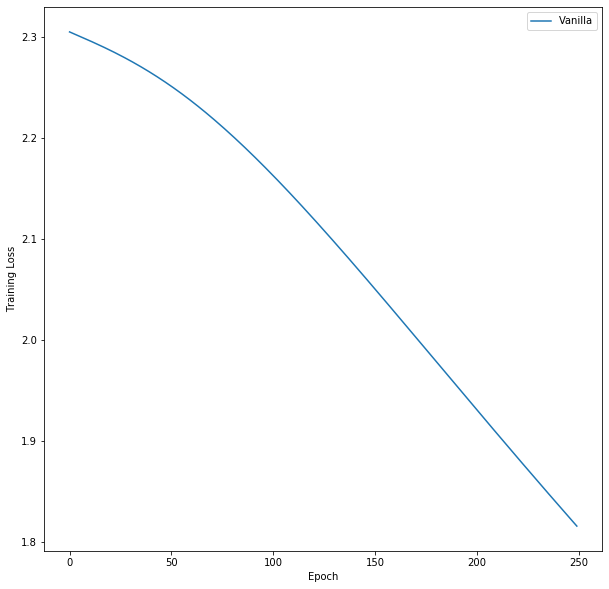

In [5]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# Momentum Gradient Descent

Next we will add momentum. The the new update rule is:

$$m_{t}=\beta_{1} m_{t-1} + (1 - \beta_{1})\nabla f(\theta_{t-1})$$
---

$$ \beta_1 \in [0,1)$$
---

$$\theta_{t}=\theta_{t-1} - \alpha m_{t} \tag{2}$$
---

In [6]:

"""
Momentum Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250
beta_1 = 0.9
"""
You need to add another hyper parameter here. Hint! look at the equation above
"""

# data for analysis
momentum_loss = []

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

"""
You probably need to initialize your momentum here... 
"""
m_w1 = 0
m_w2 = 0
m_b1 = 0
m_b2 = 0
# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])
        
        m_w1 = beta_1*m_w1 + (1-beta_1)*grad_W1
        m_w2 = beta_1*m_w2 + (1-beta_1)*grad_W2

        m_b1 = beta_1*m_b1 + (1-beta_1)*grad_b1
        m_b2 = beta_1*m_b2 + (1-beta_1)*grad_b2
        
        W1 -= eta * m_w1
        W2 -= eta * m_w2
        
        b1 -= eta*m_b1
        b2 -= eta*m_b2

        

        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    momentum_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.305424 Accuracy 0.095143
Epoch 10 Loss 2.296598 Accuracy 0.095143
Epoch 20 Loss 2.287185 Accuracy 0.095143
Epoch 30 Loss 2.276716 Accuracy 0.118000
Epoch 40 Loss 2.264920 Accuracy 0.182857
Epoch 50 Loss 2.251641 Accuracy 0.266000
Epoch 60 Loss 2.236801 Accuracy 0.374286
Epoch 70 Loss 2.220412 Accuracy 0.470286
Epoch 80 Loss 2.202590 Accuracy 0.551143
Epoch 90 Loss 2.183494 Accuracy 0.594000
Epoch 100 Loss 2.163282 Accuracy 0.617429
Epoch 110 Loss 2.142120 Accuracy 0.624000
Epoch 120 Loss 2.120170 Accuracy 0.624571
Epoch 130 Loss 2.097582 Accuracy 0.627143
Epoch 140 Loss 2.074492 Accuracy 0.628000
Epoch 150 Loss 2.051017 Accuracy 0.631429
Epoch 160 Loss 2.027263 Accuracy 0.630286
Epoch 170 Loss 2.003341 Accuracy 0.629429
Epoch 180 Loss 1.979348 Accuracy 0.633143
Epoch 190 Loss 1.955353 Accuracy 0.635143
Epoch 200 Loss 1.931414 Accuracy 0.637143
Epoch 210 Loss 1.907582 Accuracy 0.640571
Epoch 220 Loss 1.883903 Accuracy 0.643429
Epoch 230 Loss 1.860413 Accuracy 0.647714
Epo

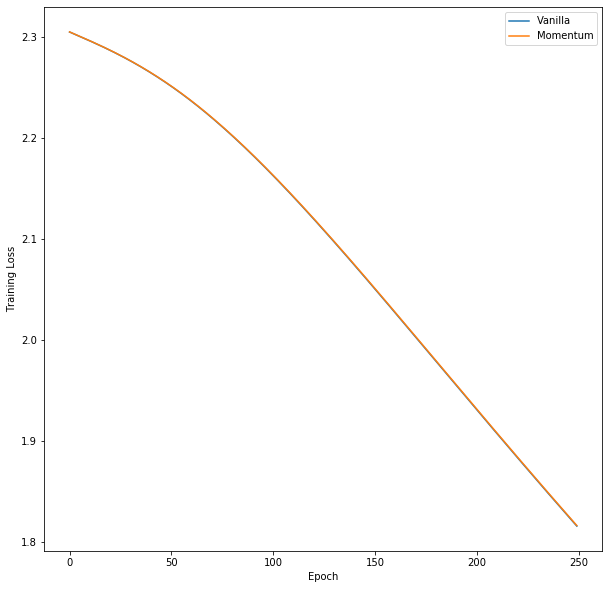

In [7]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# RMSProp Gradient Descent 

Next we will do RMSProp. The update rule is as follows:

$$v_{t} = \beta_{2}v_{t-1} + (1 - \beta_{2})\nabla f(\theta_{t-1})^2$$
---

$$ \beta_2 \in [0,1)$$
---

$$\theta_{t} = \theta_{t-1} - \alpha \frac { \nabla f(\theta_{t-1})}{\sqrt{v_{t} + \epsilon}} \tag{3}$$ 
---


In [10]:
"""
RMSProp Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250
"""
You need to add two hyper parameters here. Hint! look at the equation above
"""

beta_2 = 0.5
epsilon = 0.0000000000000001


# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
RMS_loss = []

"""
You probably need to initialize your variance here...
"""

v_w1 = np.zeros_like(W1)
v_w2 = np.zeros_like(W2)
v_b1 = np.zeros_like(b1)
v_b2 = np.zeros_like(b2)


# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """
        v_w1 = beta_2*v_w1 + (1-beta_2)*grad_W1**2
        v_w2 = beta_2*v_w2 + (1-beta_2)*grad_W2**2
        
        v_b1 = beta_2*v_b1 + (1-beta_2)*grad_b1**2
        v_b2 = beta_2*v_b2 + (1-beta_2)*grad_b2**2

        W1 -= eta*(grad_W1/np.sqrt(v_w1 + epsilon))
        W2 -= eta*(grad_W2/np.sqrt(v_w2 + epsilon))
        b1 -= eta*(grad_b1/np.sqrt(v_b1 + epsilon))
        b2 -= eta*(grad_b2/np.sqrt(v_b2 + epsilon))

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    RMS_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.202921 Accuracy 0.428857
Epoch 10 Loss 1.441780 Accuracy 0.856000
Epoch 20 Loss 0.926481 Accuracy 0.887714
Epoch 30 Loss 0.628378 Accuracy 0.899714
Epoch 40 Loss 0.462930 Accuracy 0.909714
Epoch 50 Loss 0.367192 Accuracy 0.914857
Epoch 60 Loss 0.307187 Accuracy 0.918286
Epoch 70 Loss 0.266116 Accuracy 0.921714
Epoch 80 Loss 0.236084 Accuracy 0.922857
Epoch 90 Loss 0.213170 Accuracy 0.924857
Epoch 100 Loss 0.195110 Accuracy 0.926571
Epoch 110 Loss 0.180369 Accuracy 0.928857
Epoch 120 Loss 0.168075 Accuracy 0.928286
Epoch 130 Loss 0.157557 Accuracy 0.928857
Epoch 140 Loss 0.148385 Accuracy 0.928000
Epoch 150 Loss 0.140423 Accuracy 0.928000
Epoch 160 Loss 0.133415 Accuracy 0.929429
Epoch 170 Loss 0.127124 Accuracy 0.930000
Epoch 180 Loss 0.121440 Accuracy 0.930286
Epoch 190 Loss 0.116245 Accuracy 0.931143
Epoch 200 Loss 0.111496 Accuracy 0.931143
Epoch 210 Loss 0.107106 Accuracy 0.931143
Epoch 220 Loss 0.103086 Accuracy 0.932286
Epoch 230 Loss 0.099371 Accuracy 0.931714
Epo

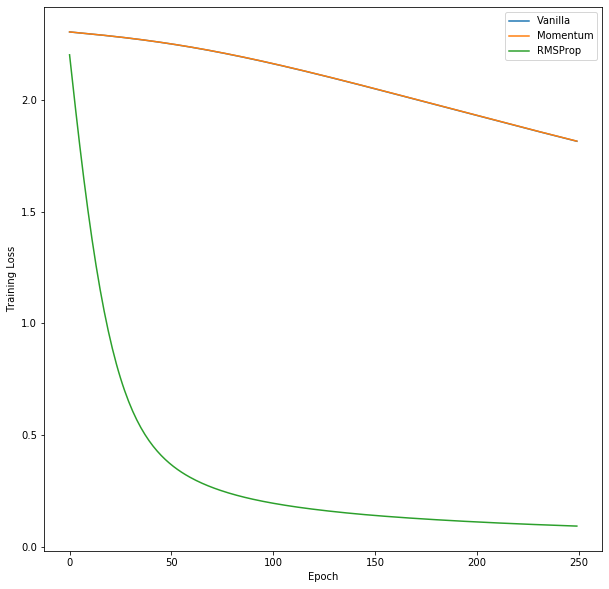

In [11]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.plot(RMS_loss, label='RMSProp')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# Adam Gradient Descent 

Now we put them both together and we get Adam!

$$m_{t}=\beta_{1} m_{t-1} + (1 - \beta_{1})\nabla f(\theta_{t-1})$$
---

$$v_{t} = \beta_{2}v_{t-1} + (1 - \beta_{2})\nabla f(\theta_{t-1})^2$$
---

$$\hat m_{t} = \frac {m_{t}}{1 - \beta_1^{t}}$$
---

$$\hat v_t = \frac {v_{t}}{1 - \beta_2^{t}}$$
---

$$\theta_t = \theta_{t-1} - \alpha \frac {\hat m_t}{\sqrt{\hat v_t + \epsilon}} \tag{4}$$
---

Play around with the hyperparameters to see if you can get distinctly different behavior from the optimization.

In [21]:
"""
Adam Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250
"""
You need to add 3 hyper parameters here. Hint! look at the equation above
"""
beta_1 = 0.99
beta_2 = 0.999
epsilon = 0.0000000000000001


# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
Adam_loss = []

v_w1 = np.zeros_like(W1)
v_w2 = np.zeros_like(W2)
v_b1 = np.zeros_like(b1)
v_b2 = np.zeros_like(b2)

m_w1 = np.zeros_like(W1)
m_w2 = np.zeros_like(W2)
m_b1 = np.zeros_like(b1)
m_b2 = np.zeros_like(b2)

"""
You probably need to initialize your variance and momentum here...
"""

T = 1

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """
        
        # Biased estimates
        m_w1 = beta_1*m_w1 + (1-beta_1)*grad_W1
        m_w2 = beta_1*m_w2 + (1-beta_1)*grad_W2

        m_b1 = beta_1*m_b1 + (1-beta_1)*grad_b1
        m_b2 = beta_1*m_b2 + (1-beta_1)*grad_b2
        
        v_w1 = beta_2*v_w1 + (1-beta_2)*grad_W1**2
        v_w2 = beta_2*v_w2 + (1-beta_2)*grad_W2**2
        
        v_b1 = beta_2*v_b1 + (1-beta_2)*grad_b1**2
        v_b2 = beta_2*v_b2 + (1-beta_2)*grad_b2**2
        
        # Bias correction
        m2_w1 = m_w1/(1-beta_1**T)
        m2_w2 = m_w2/(1-beta_1**T)
        
        m2_b1 = m_b1/(1-beta_1**T)
        m2_b2 = m_b2/(1-beta_1**T)
        
        v2_w1 = v_w1/(1-beta_2**T)
        v2_w2 = v_w2/(1-beta_2**T)
        
        v2_b1 = v_b1/(1-beta_2**T)
        v2_b2 = v_b2/(1-beta_2**T)
        
        # Take step
        W1 -= eta*(m2_w1/np.sqrt(v2_w1 + epsilon))
        W2 -= eta*(m2_w2/np.sqrt(v2_w2 + epsilon))
        b1 -= eta*(m2_b1/np.sqrt(v2_b1 + epsilon))
        b2 -= eta*(m2_b2/np.sqrt(v2_b2 + epsilon))
        
    T += 1

        

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    Adam_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 1.935239 Accuracy 0.757143
Epoch 10 Loss 0.755679 Accuracy 0.902000
Epoch 20 Loss 0.552165 Accuracy 0.910000
Epoch 30 Loss 0.449204 Accuracy 0.914000
Epoch 40 Loss 0.382257 Accuracy 0.916571
Epoch 50 Loss 0.333862 Accuracy 0.918857
Epoch 60 Loss 0.297002 Accuracy 0.920000
Epoch 70 Loss 0.267969 Accuracy 0.921714
Epoch 80 Loss 0.244429 Accuracy 0.923143
Epoch 90 Loss 0.224817 Accuracy 0.925429
Epoch 100 Loss 0.208260 Accuracy 0.926286
Epoch 110 Loss 0.194095 Accuracy 0.927714
Epoch 120 Loss 0.181730 Accuracy 0.928286
Epoch 130 Loss 0.170913 Accuracy 0.930000
Epoch 140 Loss 0.161393 Accuracy 0.930857
Epoch 150 Loss 0.152805 Accuracy 0.931714
Epoch 160 Loss 0.144964 Accuracy 0.931714
Epoch 170 Loss 0.137834 Accuracy 0.931714
Epoch 180 Loss 0.131305 Accuracy 0.932000
Epoch 190 Loss 0.125254 Accuracy 0.932286
Epoch 200 Loss 0.119653 Accuracy 0.933143
Epoch 210 Loss 0.114460 Accuracy 0.933714
Epoch 220 Loss 0.109631 Accuracy 0.933429
Epoch 230 Loss 0.105092 Accuracy 0.933143
Epo

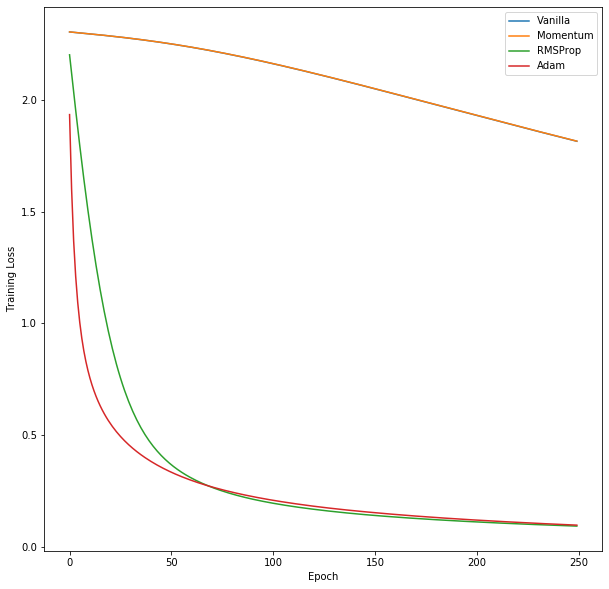

In [22]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.plot(RMS_loss, label='RMSProp')
plt.plot(Adam_loss, label='Adam')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

In [19]:
"""
AdaMax Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250
"""
You need to add 3 hyper parameters here. Hint! look at the equation above
"""
beta_1 = 0.99
beta_2 = 0.999
epsilon = 0.0000000000000001


# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
AdaMax_loss = []

v_w1 = np.zeros_like(W1)
v_w2 = np.zeros_like(W2)
v_b1 = np.zeros_like(b1)
v_b2 = np.zeros_like(b2)

m_w1 = np.zeros_like(W1)
m_w2 = np.zeros_like(W2)
m_b1 = np.zeros_like(b1)
m_b2 = np.zeros_like(b2)

"""
You probably need to initialize your variance and momentum here...
"""

T = 1

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """
        
        # Biased estimates
        m_w1 = beta_1*m_w1 + (1-beta_1)*grad_W1
        m_w2 = beta_1*m_w2 + (1-beta_1)*grad_W2

        m_b1 = beta_1*m_b1 + (1-beta_1)*grad_b1
        m_b2 = beta_1*m_b2 + (1-beta_1)*grad_b2
        
        v_w1 = np.maximum(beta_2*v_w1, np.abs(grad_W1))
        v_w2 = np.maximum(beta_2*v_w2, np.abs(grad_W2))
        
        v_b1 = np.maximum(beta_2*v_b1, np.abs(grad_b1))
        v_b2 = np.maximum(beta_2*v_b2, np.abs(grad_b2))
        
        # Take step
        W1 -= (eta*(1-beta_1**T)) * m_w1/v_w1
        W2 -= (eta*(1-beta_1**T)) * m_w2/v_w2
        b1 -= (eta*(1-beta_1**T)) * m_b1/v_b1
        b2 -= (eta*(1-beta_1**T)) * m_b2/v_b2

        
    T += 1
    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    AdaMax_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.305970 Accuracy 0.095143
Epoch 10 Loss 2.270100 Accuracy 0.095143
Epoch 20 Loss 2.199267 Accuracy 0.425143
Epoch 30 Loss 2.092365 Accuracy 0.744857
Epoch 40 Loss 1.948965 Accuracy 0.785714
Epoch 50 Loss 1.778990 Accuracy 0.808857
Epoch 60 Loss 1.593841 Accuracy 0.833429
Epoch 70 Loss 1.404651 Accuracy 0.852571
Epoch 80 Loss 1.221701 Accuracy 0.866286
Epoch 90 Loss 1.053143 Accuracy 0.879714
Epoch 100 Loss 0.904162 Accuracy 0.890857
Epoch 110 Loss 0.776836 Accuracy 0.896571
Epoch 120 Loss 0.670739 Accuracy 0.902857
Epoch 130 Loss 0.583825 Accuracy 0.906286
Epoch 140 Loss 0.513173 Accuracy 0.908857
Epoch 150 Loss 0.455706 Accuracy 0.912286
Epoch 160 Loss 0.408673 Accuracy 0.914286
Epoch 170 Loss 0.369850 Accuracy 0.916286
Epoch 180 Loss 0.337456 Accuracy 0.918571
Epoch 190 Loss 0.310121 Accuracy 0.920286
Epoch 200 Loss 0.286797 Accuracy 0.920571
Epoch 210 Loss 0.266683 Accuracy 0.922571
Epoch 220 Loss 0.249166 Accuracy 0.923429
Epoch 230 Loss 0.233758 Accuracy 0.924571
Epo

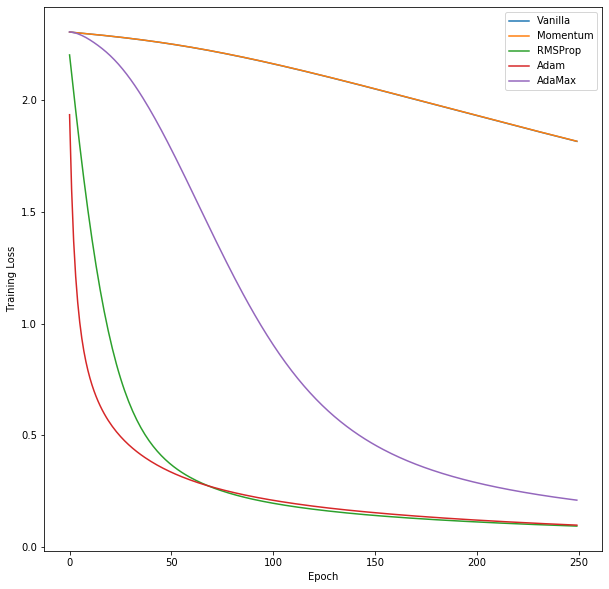

In [23]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.plot(RMS_loss, label='RMSProp')
plt.plot(Adam_loss, label='Adam')
plt.plot(AdaMax_loss, label='AdaMax')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()